# Extending linear models

## Imports

In [14]:
%config InlineBackend.figure_format="retina"

In [55]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
from pandas import DataFrame
from scipy import stats

## Transforming covariates

Can transform covariates—$\mathbf{X}$—to
make relationship between $\mathbf{X}$ and $Y$ nonlinear—such
as taking the square root
or log.

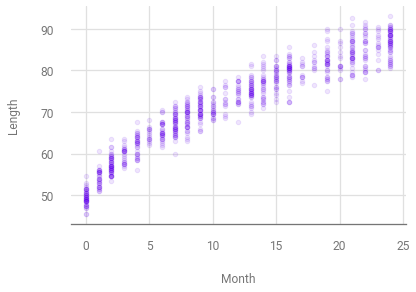

In [10]:
babies = pd.read_csv(
    "https://raw.githubusercontent.com"
    "/BayesianModelingandComputationInPython/BookCode_Edition1/main"
    "/data/babies.csv"
).assign(Intercept=1)
babies.plot.scatter(x="Month", y="Length", alpha=0.1);

In [13]:
with pm.Model() as model_baby_linear:
    β = pm.Normal("β", sigma=10, shape=2)

    μ = pm.Deterministic("μ", pm.math.dot(babies[["Intercept", "Month"]], β))
    ϵ = pm.HalfNormal("ϵ", sigma=10)

    length = pm.Normal("length", mu=μ, sigma=ϵ, observed=babies["Length"])

    trace_linear = pm.sample(draws=2_000, tune=4_000)
    pcc_linear = pm.sample_posterior_predictive(trace_linear)
    inf_data_linear = az.from_pymc3(trace=trace_linear, posterior_predictive=pcc_linear)

/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β]


Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 38 seconds.


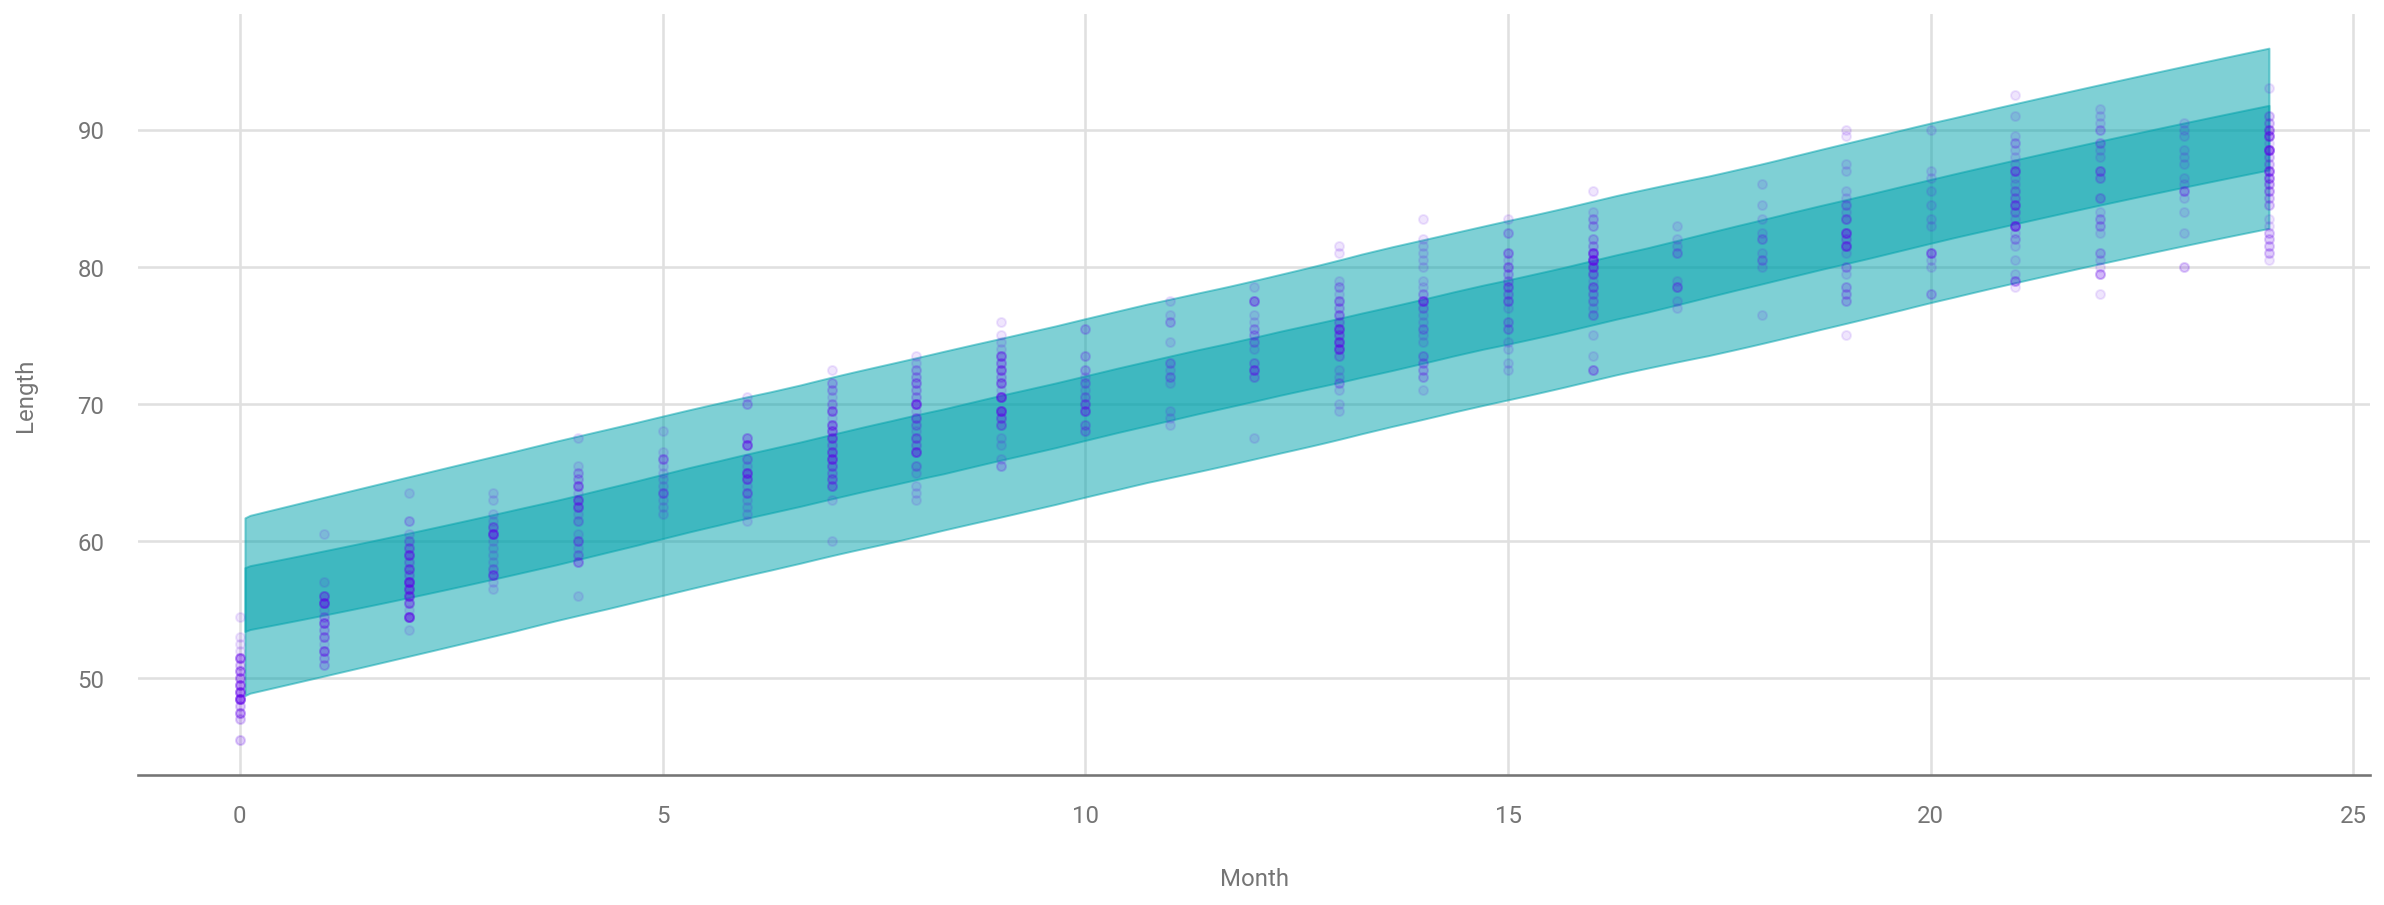

In [18]:
_, ax = plt.subplots(figsize=(20, 7))

for hdi_prob in [0.50, 0.94]:
    az.plot_hdi(
        babies["Month"],
        inf_data_linear["posterior_predictive"]["length"],
        hdi_prob=hdi_prob,
        ax=ax,
    )
babies.plot.scatter(x="Month", y="Length", alpha=0.1, ax=ax);

/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β]


Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 28 seconds.
The acceptance probability does not match the target. It is 0.8942696754162789, but should be close to 0.8. Try to increase the number of tuning steps.


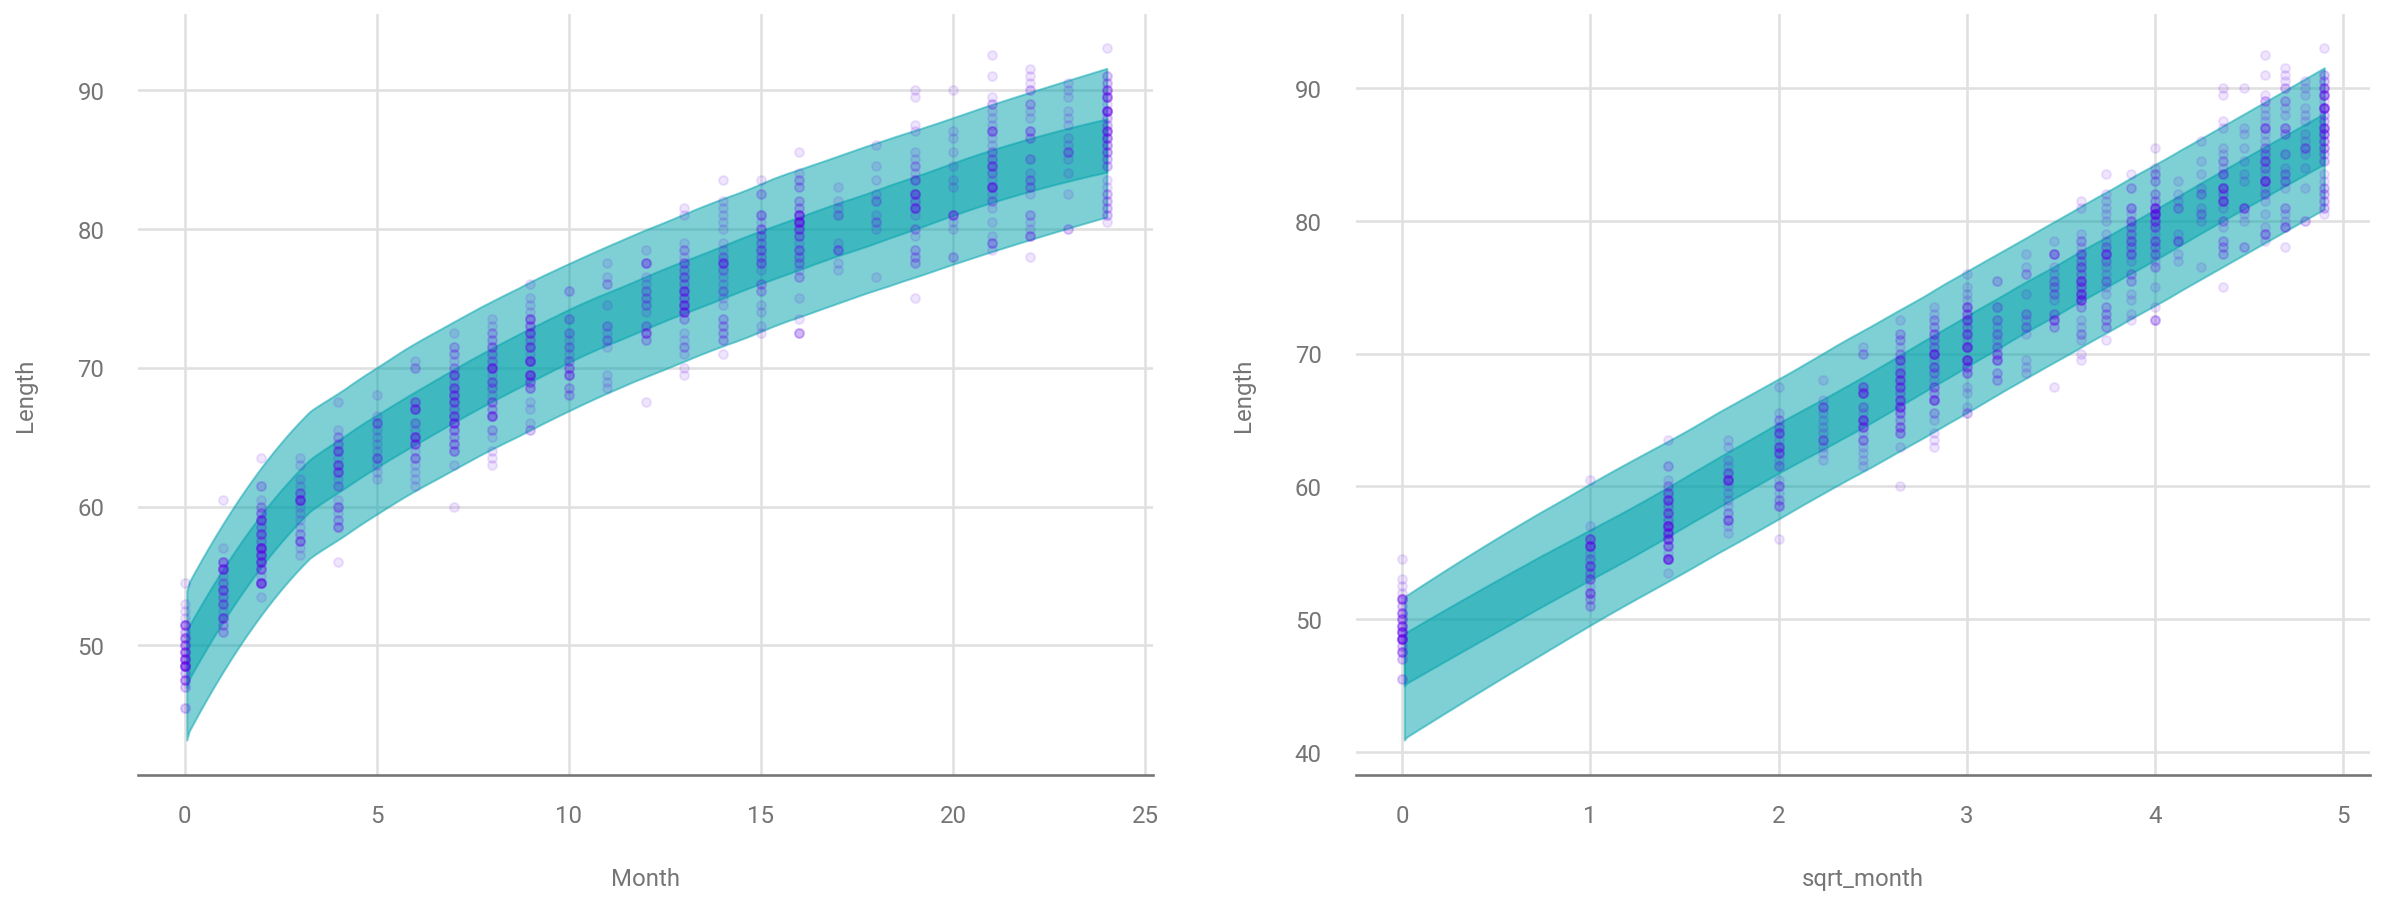

In [28]:
with pm.Model() as model_baby_sqrt:
    β = pm.Normal("β", sigma=10, shape=2)

    μ = pm.Deterministic("μ", β[0] + β[1] * np.sqrt(babies["Month"]))
    σ = pm.HalfNormal("σ", sigma=10)

    length = pm.Normal("length", mu=μ, sigma=σ, observed=babies["Length"])

    inf_data_sqrt = pm.sample(draws=2000, tune=4000)
    ppc_baby_sqrt = pm.sample_posterior_predictive(inf_data_sqrt)
    inf_data_sqrt = az.from_pymc3(
        trace=inf_data_sqrt, posterior_predictive=ppc_baby_sqrt
    )

_, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(20, 7))

for hdi_prob in [0.50, 0.94]:
    az.plot_hdi(
        babies["Month"],
        inf_data_sqrt["posterior_predictive"]["length"],
        hdi_prob=hdi_prob,
        ax=ax_left,
    )
babies.plot.scatter(x="Month", y="Length", alpha=0.1, ax=ax_left)
for hdi_prob in [0.50, 0.94]:
    az.plot_hdi(
        np.sqrt(babies["Month"]),
        inf_data_sqrt["posterior_predictive"]["length"],
        hdi_prob=hdi_prob,
        ax=ax_right,
    )
(
    babies.assign(sqrt_month=lambda df: np.sqrt(df["Month"])).plot.scatter(
        x="sqrt_month", y="Length", alpha=0.1, ax=ax_right
    )
);

## Varying uncertainty

Before we assumed variance is constant
thourought the range.
But we can also make it variable:

$$
\begin{split}
    \mu =& \beta_0 + \beta_1 f_1(X_1) + \dots + \beta_m f_m(X_m) \\
    \sigma =& \delta_0 + \delta_1 g_1(X_1) + \dots + \delta_m g_m(X_m) \\
Y \sim& \mathcal{N}(\mu, \sigma)
\end{split}
$$

/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [δ, β]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 43 seconds.


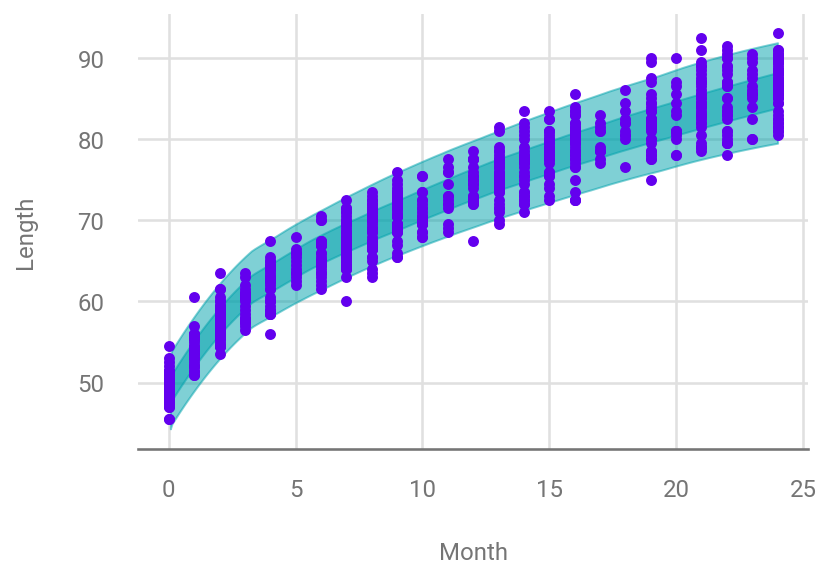

In [31]:
with pm.Model() as model_baby_vv:
    β = pm.Normal("β", sigma=10, shape=2)

    δ = pm.HalfNormal("δ", sigma=10, shape=2)
    μ = pm.Deterministic("μ", β[0] + β[1] * np.sqrt(babies["Month"]))
    σ = pm.Deterministic("σ", δ[0] + δ[1] * babies["Month"])

    length = pm.Normal("length", mu=μ, sigma=σ, observed=babies["Length"])

    trace_baby_vv = pm.sample(2000, target_accept=0.95)
    ppc_baby_vv = pm.sample_posterior_predictive(
        trace_baby_vv, var_names=["length", "σ"]
    )
    inf_data_baby_vv = az.from_pymc3(
        trace=trace_baby_vv, posterior_predictive=ppc_baby_vv
    )

_, ax = plt.subplots()
for hdi_prob in [0.50, 0.94]:
    az.plot_hdi(
        babies["Month"],
        inf_data_baby_vv.posterior_predictive["length"],
        hdi_prob=hdi_prob,
        ax=ax,
    )
babies.plot.scatter(x="Month", y="Length", ax=ax);

## Interaction effects

Covariates are not always independent.

$$
\begin{split}
    \mu =& \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_1X_2\\
    Y \sim& \mathcal{N}(\mu, \sigma)
\end{split}
$$

In [34]:
tips_df = pd.read_csv(
    "https://raw.githubusercontent.com"
    "/BayesianModelingandComputationInPython/BookCode_Edition1/main"
    "/data/tips.csv"
)
tips = tips_df["tip"]
total_bill_c = tips_df["total_bill"] - tips_df["total_bill"].mean()  # Center bill
smoker = pd.Categorical(tips_df["smoker"]).codes

with pm.Model() as model_no_interactions:
    β = pm.Normal("β", mu=0, sigma=1, shape=3)
    σ = pm.HalfNormal("σ", 1)

    μ = β[1] + β[1] * total_bill_c + β[2] * smoker

    obs = pm.Normal("obs", μ, σ, observed=tips)
    trace_no_interaction = pm.sample(1_000, tune=1_000)

with pm.Model() as model_interaction:
    β = pm.Normal("β", mu=0, sigma=1, shape=4)
    σ = pm.HalfNormal("σ", 1)

    μ = β[0] + β[1] * total_bill_c + β[2] * smoker + β[3] * smoker * total_bill_c

    obs = pm.Normal("obs", μ, σ, observed=tips)
    trace_interaction = pm.sample(1000, tune=1000)

/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


![Smoker Tip Interaction](images/chapter_4/Smoker_Tip_Interaction.png)


## Robust regression

For outliers,
can remove them with some criteria—like
3 standard deviations of 1.5 times the interquartile range—
or make model that can handle outliers—like
Student's t-distribution.

Degrees of freedom—$\nu$—for
Student's t controls the weight of the tails.
When $\nu$ is small
there is more distribution in the tails.

In [40]:
def generate_sales(*, days: int, mean: float, std: float, label: str) -> DataFrame:
    """Create dataset representing sales."""
    np.random.seed(0)
    df = pd.DataFrame(index=range(1, days + 1), columns=["customers", "sales"])
    for day in range(1, days + 1):
        num_customers = stats.randint(30, 100).rvs() + 1

        # This is correct as there is an independent draw for each customers orders
        dollar_sales = stats.norm(mean, std).rvs(num_customers).sum()

        df.loc[day, "customers"] = num_customers
        df.loc[day, "sales"] = dollar_sales

    # Fix the types as not to cause Theano errors
    df = df.astype({"customers": "int32", "sales": "float32"})

    # Sorting will make plotting the posterior predictive easier later
    df["Food_Category"] = label
    df = df.sort_values("customers")
    return df

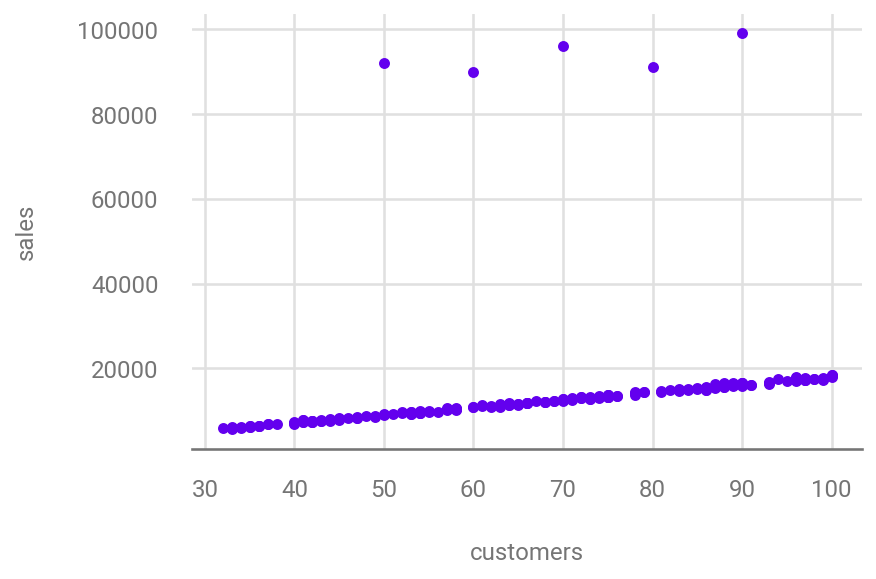

In [42]:
empanadas = generate_sales(days=200, mean=180, std=30, label="Empanada")
empanadas.iloc[0] = [50, 92000, "Empanada"]
empanadas.iloc[1] = [60, 90000, "Empanada"]
empanadas.iloc[2] = [70, 96000, "Empanada"]
empanadas.iloc[3] = [80, 91000, "Empanada"]
empanadas.iloc[4] = [90, 99000, "Empanada"]
empanadas = empanadas.sort_values("customers")

empanadas.plot.scatter(x="customers", y="sales");

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
The acceptance probability does not match the target. It is 0.8860777877942666, but should be close to 0.8. Try to increase the number of tuning steps.


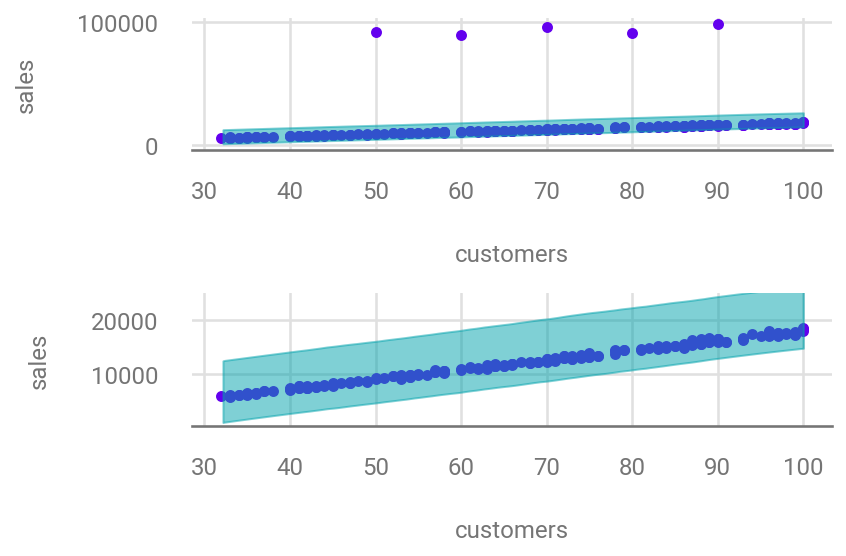

In [50]:
with pm.Model() as model_non_robust:
    σ = pm.HalfNormal("σ", 50)
    β = pm.Normal("β", mu=150, sigma=20)

    μ = pm.Deterministic("μ", β * empanadas["customers"])

    sales = pm.Normal("sales", mu=μ, sigma=σ, observed=empanadas["sales"])

    trace_empanada_sales = pm.sample(random_seed=1, return_inferencedata=False)
    ppc_empanada_sales = pm.sample_posterior_predictive(trace_empanada_sales)
    inf_data_non_robust = az.from_pymc3(
        trace=trace_empanada_sales, posterior_predictive=ppc_empanada_sales
    )

_, (top_ax, bottom_ax) = plt.subplots(2)

for ax in [top_ax, bottom_ax]:
    empanadas.plot.scatter(x="customers", y="sales", ax=ax)
    az.plot_hdi(
        empanadas["customers"],
        inf_data_non_robust.posterior_predictive["sales"],
        hdi_prob=0.95,
        ax=ax,
    )

bottom_ax.set_ylim(400, 25000)
plt.tight_layout();

In [49]:
az.summary(inf_data_non_robust, kind="stats", var_names=["β", "σ"])

,mean,sd,hdi_3%,hdi_97%
β,207.024,2.998,201.351,212.454
σ,2952.283,25.259,2904.297,2997.569


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


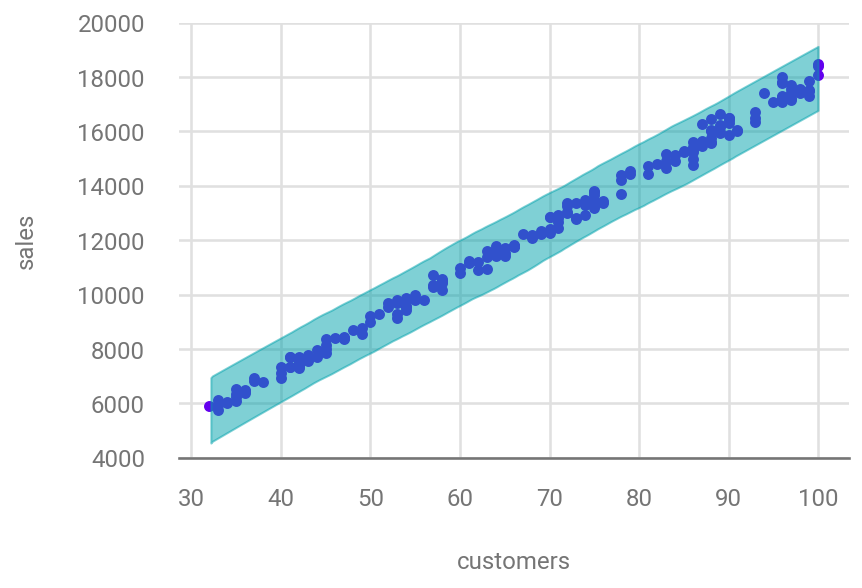

In [51]:
with pm.Model() as model_robust:
    σ = pm.HalfNormal("σ", 50)
    β = pm.Normal("β", mu=150, sigma=20)
    ν = pm.HalfNormal("ν", 20)

    μ = pm.Deterministic("μ", β * empanadas["customers"])

    sales = pm.StudentT("sales", mu=μ, sigma=σ, nu=ν, observed=empanadas["sales"])

    trace_empanada_sales_robust = pm.sample(random_seed=0, return_inferencedata=False)
    ppc_empanada_sales_robust = pm.sample_posterior_predictive(
        trace_empanada_sales_robust
    )

    inf_data_robust = az.from_pymc3(
        trace=trace_empanada_sales_robust,
        posterior_predictive=ppc_empanada_sales_robust,
    )

_, ax = plt.subplots()

empanadas.plot.scatter(x="customers", y="sales", ax=ax)
(
    az.plot_hdi(
        empanadas["customers"],
        inf_data_robust.posterior_predictive["sales"],
        hdi_prob=0.95,
        ax=ax,
    ).set(ylim=(4_000, 20_000))
);

In [52]:
az.summary(inf_data_robust, var_names=["β", "σ", "ν"], kind="stats")

,mean,sd,hdi_3%,hdi_97%
β,179.605,0.261,179.111,180.076
σ,151.989,13.942,126.355,178.442
ν,1.287,0.167,0.989,1.601


Big reduction in $\sigma$ in Student-t model

## Pooling, multilevel models, and mixed effects

Some dataset contain additional nested structures—resulting
in some heirarchical data groups.

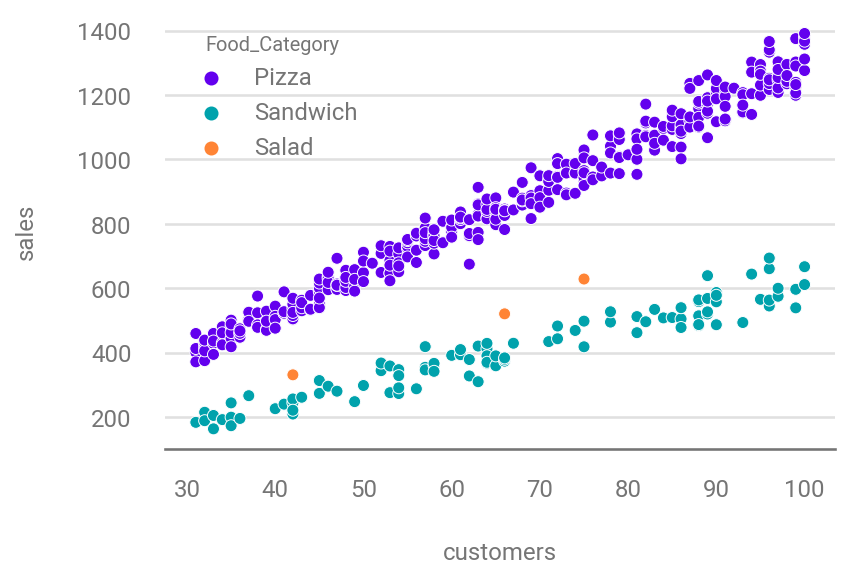

In [58]:
pizza_df = generate_sales(days=365, mean=13, std=5, label="Pizza")
sandwich_df = generate_sales(days=100, mean=6, std=5, label="Sandwich")
salad_df = generate_sales(days=3, mean=8, std=3, label="Salad")
sales_df = pd.concat([pizza_df, sandwich_df, salad_df]).reset_index(drop=True)

sales_df.pipe((sns.scatterplot, "data"), x="customers", y="sales", hue="Food_Category");

### Unpooled parameters

In [73]:
customers = sales_df.loc[:, "customers"].to_numpy()
sales_observed = sales_df.loc[:, "sales"].to_numpy()
food_category = pd.Categorical(sales_df["Food_Category"])

with pm.Model(
    coords={"food_category": food_category.categories}
) as model_sales_unpooled:
    σ = pm.HalfNormal("σ", sigma=20, dims="food_category")
    β = pm.Normal("β", mu=10, sigma=10, dims="food_category")
    μ = pm.Deterministic("μ", β[food_category.codes] * customers)
    sales = pm.Normal(
        "sales", mu=μ, sigma=σ[food_category.codes], observed=sales_observed
    )
    trace_sales_unpooled = pm.sample(target_accept=0.9, return_inferencedata=False)
    inf_data_sales_unpooled = az.from_pymc3(trace=trace_sales_unpooled)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


In [65]:
pm.model_to_graphviz(model_sales_unpooled)

ImportError: This function requires the python library graphviz, along with binaries. The easiest way to install all of this is by running

	conda install -c conda-forge python-graphviz

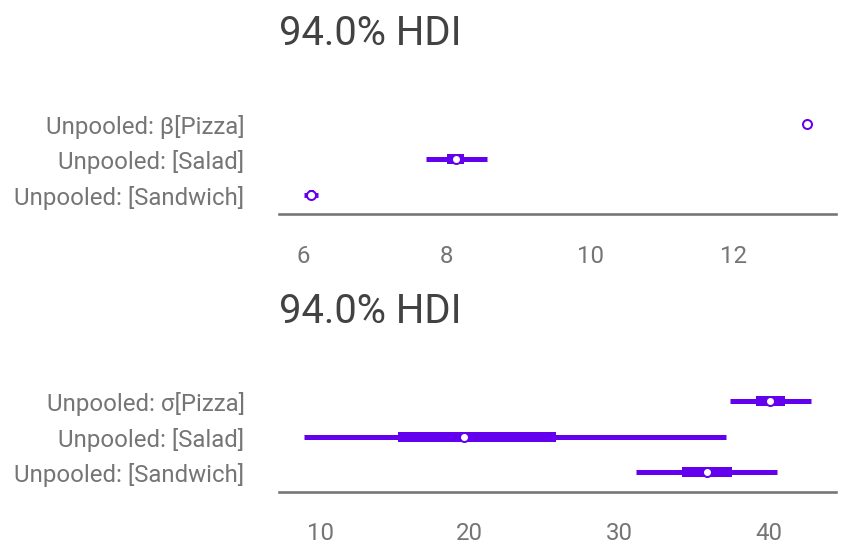

In [70]:
_, axes = plt.subplots(2)
for var_name, ax in zip(["β", "σ"], axes):
    az.plot_forest(
        [inf_data_sales_unpooled],
        model_names=["Unpooled"],
        var_names=[var_name],
        combined=True,
        ax=ax,
    )
plt.tight_layout();

$\beta$ is widest for salad,
and $\sigma$ is vary wide for salad.
Result is identical to creating three seperate models
with subsets of the data.

### Pooled parameters

In [76]:
with pm.Model() as model_sales_pooled:
    σ = pm.HalfNormal("σ", sigma=20)
    β = pm.Normal("β", mu=10, sigma=10)

    μ = pm.Deterministic("μ", var=β * customers)

    sales = pm.Normal("sales", mu=μ, sigma=σ, observed=sales_observed)

    trace_data_sales_pooled = pm.sample(return_inferencedata=False)
    ppc_sales_pooled = pm.sample_posterior_predictive(trace_data_sales_pooled)
    inf_data_sales_pooled = az.from_pymc3(
        trace=trace_data_sales_pooled,
        posterior_predictive=ppc_sales_pooled,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


In [86]:
pm.model_to_graphviz(model_sales_pooled)

ImportError: This function requires the python library graphviz, along with binaries. The easiest way to install all of this is by running

	conda install -c conda-forge python-graphviz

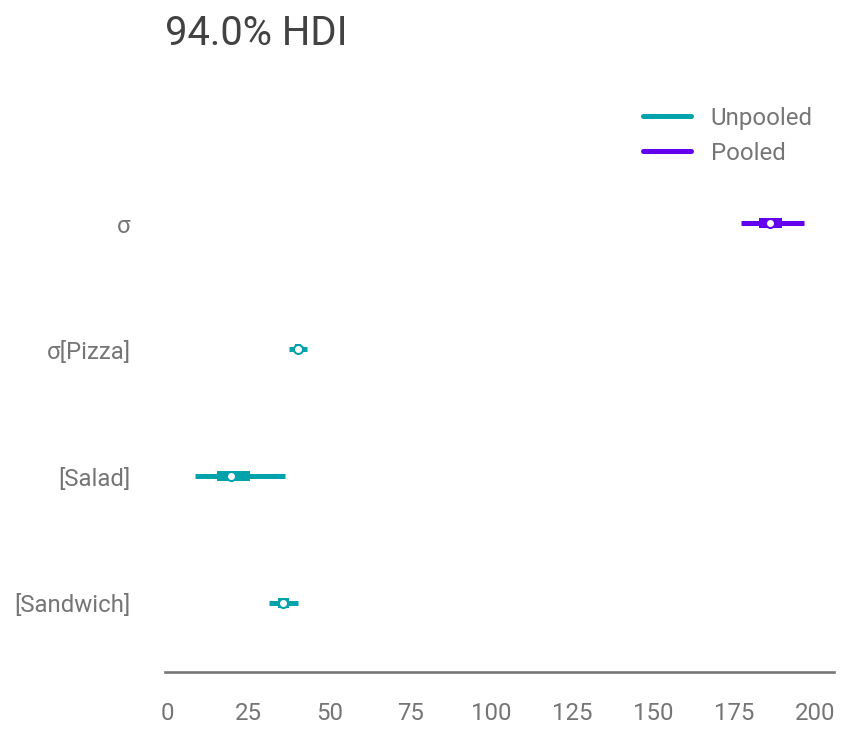

In [80]:
az.plot_forest(
    [inf_data_sales_pooled, inf_data_sales_unpooled],
    model_names=["Pooled", "Unpooled"],
    var_names=["σ"],
    combined=True,
);

Pooled means more data for each parameter,
but we don't understand each group individually.

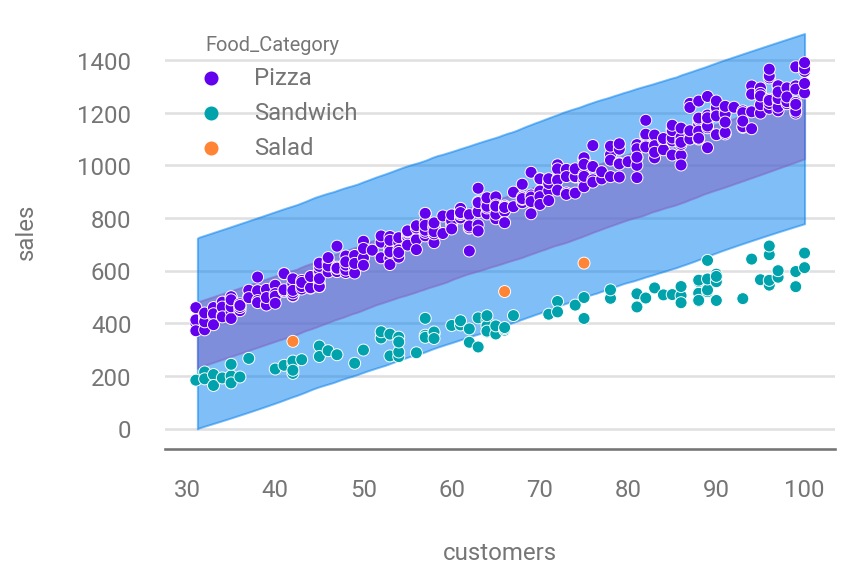

In [84]:
_, ax = plt.subplots()

for i, hdi_prob in enumerate([0.50, 0.95]):
    az.plot_hdi(
        customers,
        inf_data_sales_pooled["posterior_predictive"]["sales"],
        hdi_prob=hdi_prob,
        ax=ax,
        color=f"C{i + 3}",
    )
sales_df.pipe(
    (sns.scatterplot, "data"),
    x="customers",
    y="sales",
    hue="Food_Category",
    ax=ax,
);

### Mixing group and common parameters

Can pool only some parameters instead.

In [85]:
with pm.Model(
    coords={"food_category": food_category.categories}
) as model_pooled_sigma_sales:
    σ = pm.HalfNormal("σ", sigma=20)
    β = pm.Normal("β", mu=10, sigma=20, dims="food_category")

    μ = pm.Deterministic("μ", var=β[food_category.codes] * customers)
    sales = pm.Normal("sales", mu=μ, sigma=σ, observed=sales_observed)

    trace_pooled_sigma_sales = pm.sample(return_inferencedata=False)
    ppc_pooled_sigma_sales = pm.sample_posterior_predictive(trace_pooled_sigma_sales)

    inf_data_pooled_sigma_sales = az.from_pymc3(
        trace=trace_pooled_sigma_sales,
        posterior_predictive=ppc_pooled_sigma_sales,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


In [87]:
pm.model_to_graphviz(model_pooled_sigma_sales)

ImportError: This function requires the python library graphviz, along with binaries. The easiest way to install all of this is by running

	conda install -c conda-forge python-graphviz

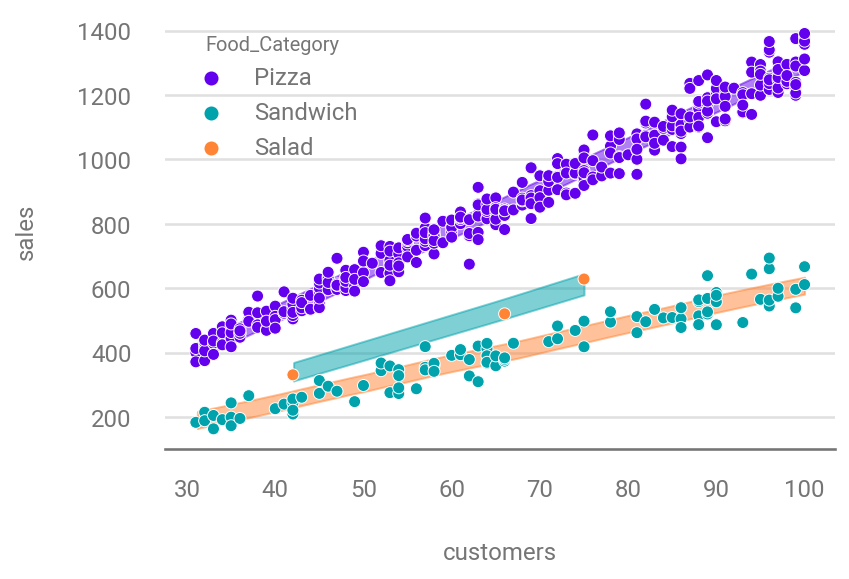

In [131]:
_, ax = plt.subplots()
for idx, food in enumerate(food_category.categories):
    food_category_mask = sales_df["Food_Category"] == food
    az.plot_hdi(
        sales_df["customers"][food_category_mask],
        inf_data_pooled_sigma_sales["posterior_predictive"]["sales"][
            :, :, food_category_mask
        ],
        hdi_prob=0.5,
        ax=ax,
        color=f"C{idx}",
    )

sales_df.pipe(
    (sns.scatterplot, "data"),
    x="customers",
    y="sales",
    hue="Food_Category",
    ax=ax,
);

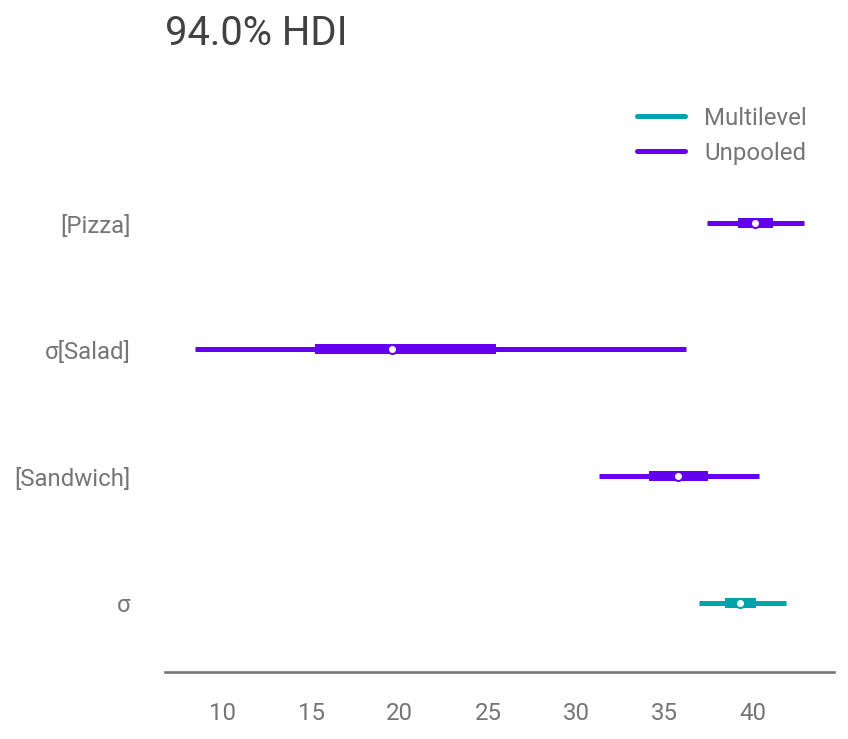

In [134]:
az.plot_forest(
    [inf_data_sales_unpooled, inf_data_pooled_sigma_sales],
    model_names=["Unpooled", "Multilevel "],
    var_names=["σ"],
    combined=True,
);